##ANALISIS DATASET PENJUALAN MOBIL DARI SALES


https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data

#Materi12 and 13

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
data = pd.read_csv('car_prices.csv')
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col

# Buat SparkSession
spark = SparkSession.builder.appName("Data Cleaning").getOrCreate()

# Load data
data = spark.read.csv("car_prices.csv", header=True, inferSchema=True)

# ===== 1. Tangani Missing Values =====

# a. Kolom dengan data kosong kecil (< 1%)
# Isi nilai kosong di kolom numerik 'odometer' dengan rata-rata
avg_odometer = data.select(mean('odometer')).collect()[0][0]
data = data.fillna({'odometer': avg_odometer})

# Hapus baris dengan nilai kosong di 'mmr', 'sellingprice', atau 'saledate'
data = data.dropna(subset=['mmr', 'sellingprice', 'saledate'])

# b. Kolom dengan data kosong sedang (1%-20%)
# Isi nilai kosong pada kolom kategorikal dengan "unknown"
data = data.fillna({'make': 'unknown', 'model': 'unknown', 'trim': 'unknown',
                    'color': 'unknown', 'interior': 'unknown'})

# c. Kolom dengan data kosong tinggi (> 50%)
# Hapus kolom 'transmission' karena terlalu banyak nilai kosong
data = data.drop('transmission')

# d. Kolom target (condition)
# Hapus baris dengan target kosong
data = data.dropna(subset=['condition'])

data = data.fillna({'body': 'Unknown'})
# ===== 2. Validasi Setelah Penanganan =====
# Periksa kembali jumlah missing values per kolom
missing_counts = data.select([col(c).isNull().cast("int").alias(c) for c in data.columns]).groupBy().sum()
missing_counts.show()

# ===== Dataset Siap untuk Langkah Selanjutnya =====
# Simpan atau gunakan untuk visualisasi dan pemodelan
data.show(10)


+---------+---------+----------+---------+---------+--------+----------+--------------+-------------+----------+-------------+-----------+--------+-----------------+-------------+
|sum(year)|sum(make)|sum(model)|sum(trim)|sum(body)|sum(vin)|sum(state)|sum(condition)|sum(odometer)|sum(color)|sum(interior)|sum(seller)|sum(mmr)|sum(sellingprice)|sum(saledate)|
+---------+---------+----------+---------+---------+--------+----------+--------------+-------------+----------+-------------+-----------+--------+-----------------+-------------+
|        0|        0|         0|        0|        0|       0|         0|             0|            0|         0|            0|          0|       0|                0|            0|
+---------+---------+----------+---------+---------+--------+----------+--------------+-------------+----------+-------------+-----------+--------+-----------------+-------------+

+----+---------+-------------------+--------------------+-----------+-----------------+-----+------

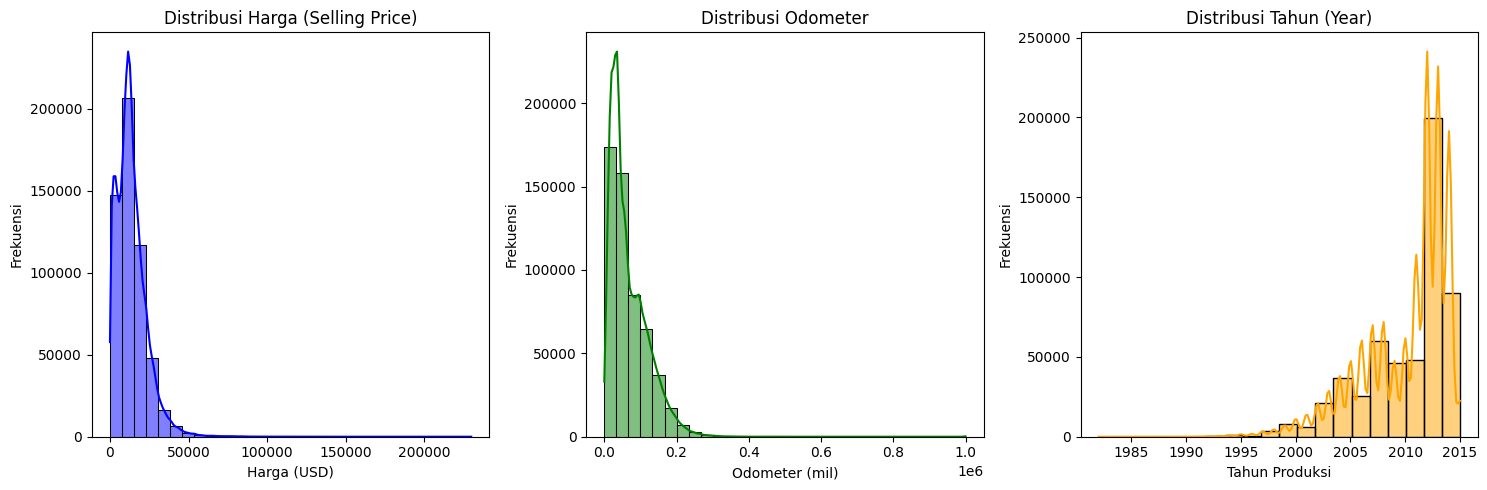

<Figure size 640x480 with 0 Axes>

In [ ]:
# Konversi Spark DataFrame ke Pandas DataFrame
data_pd = data.select(['year', 'make', 'model', 'body', 'condition',
                       'odometer', 'color', 'interior', 'sellingprice']).toPandas()


# Distribusi fitur numerik
plt.figure(figsize=(15, 5))

# Plot untuk sellingprice
plt.subplot(1, 3, 1)
sns.histplot(data=data_pd, x='sellingprice', kde=True, bins=30, color='blue')
plt.title('Distribusi Harga (Selling Price)')
plt.xlabel('Harga (USD)')
plt.ylabel('Frekuensi')

# Plot untuk odometer
plt.subplot(1, 3, 2)
sns.histplot(data=data_pd, x='odometer', kde=True, bins=30, color='green')
plt.title('Distribusi Odometer')
plt.xlabel('Odometer (mil)')
plt.ylabel('Frekuensi')

# Plot untuk year
plt.subplot(1, 3, 3)
sns.histplot(data=data_pd, x='year', kde=True, bins=20, color='orange')
plt.title('Distribusi Tahun (Year)')
plt.xlabel('Tahun Produksi')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()



plt.tight_layout()
plt.show()

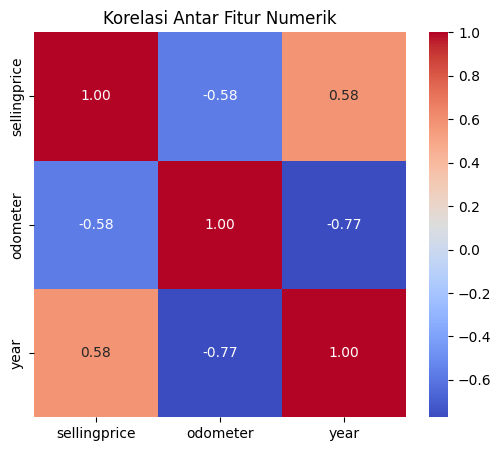

In [ ]:
# Korelasi antar fitur numerik
plt.figure(figsize=(6, 5))
corr = datapd[['sellingprice', 'odometer', 'year']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Fitur Numerik')
plt.show()


<ipython-input-21-ccd544c47a6d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_pd, y='body', order=data_pd['body'].value_counts().index, palette='viridis')


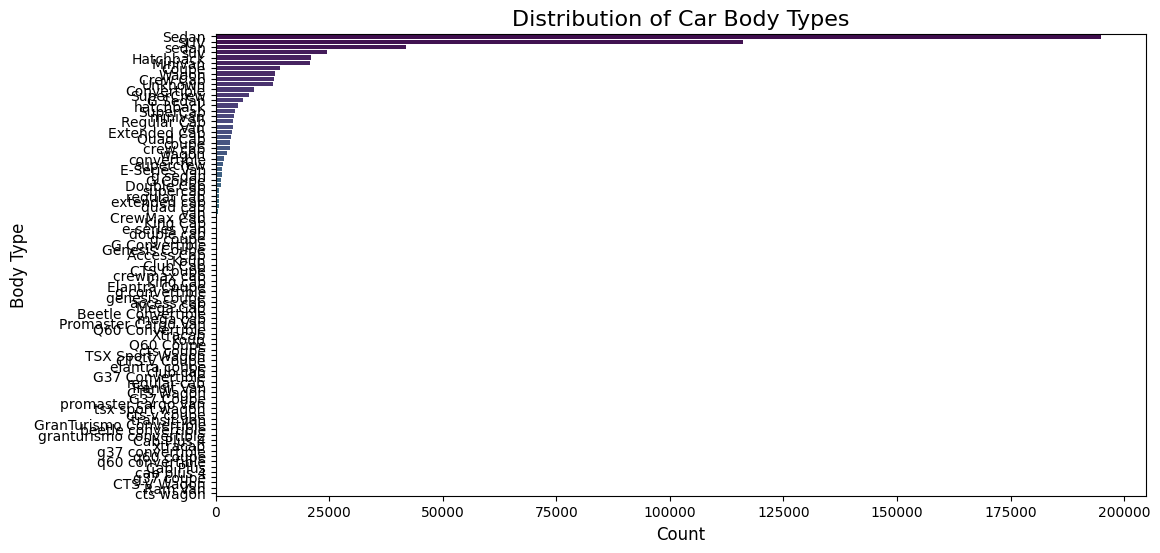

In [ ]:

# Plot distribution of car body types
plt.figure(figsize=(12, 6))
sns.countplot(data=data_pd, y='body', order=data_pd['body'].value_counts().index, palette='viridis')
plt.title('Distribution of Car Body Types', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Body Type', fontsize=12)
plt.show()

#Materi 14

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Pilih fitur untuk model (numerik & kategorikal yang sudah diproses)
feature_columns = ['year', 'odometer', 'condition']  # Sesuaikan dengan dataset Anda
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transformasi data menjadi fitur vektor
data_transformed = assembler.transform(data)


In [ ]:
from pyspark.sql.functions import when

# Membuat label berdasarkan sellingprice (contoh kategori: "murah" atau "mahal")
data_transformed = data_transformed.withColumn(
    'label', when(col('sellingprice') < 20000, 0).otherwise(1)
)

# Hapus baris dengan nilai null di label atau fitur
data_final = data_transformed.select('features', 'label').na.drop()


In [ ]:
# Split dataset menjadi training dan testing
train_data, test_data = data_final.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.classification import LogisticRegression

# Buat model Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Latih model pada data training
lr_model = lr.fit(train_data)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Prediksi pada data pengujian
predictions = lr_model.transform(test_data)

# Evaluasi dengan BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label')
auc = evaluator.evaluate(predictions)

print(f'AUC: {auc:.2f}')


AUC: 0.79


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# 1. Membuat SparkSession
spark = SparkSession.builder.appName("CarClassification").getOrCreate()

# 2. Membaca dataset kendaraan
data = spark.read.csv("car_prices.csv", header=True, inferSchema=True)

# 3. Menambahkan kolom target `selling_speed` (cepat/lambat) berdasarkan threshold harga
threshold = data.approxQuantile("sellingprice", [0.5], 0.01)[0]  # Median selling price
data = data.withColumn("selling_speed", when(col("sellingprice") >= threshold, 1).otherwise(0))

# 4. Menangani nilai kosong (sudah bersih, ini hanya antisipasi)
data = data.dropna(subset=["condition", "odometer", "mmr", "selling_speed"])

# 5. Mengonversi kolom kategorikal
# Handle null values during StringIndexer transformation by setting handleInvalid to 'skip' or 'keep'
transmission_indexer = StringIndexer(inputCol="transmission", outputCol="transmissionIndexed", handleInvalid="skip") # Changed here
body_indexer = StringIndexer(inputCol="body", outputCol="bodyIndexed", handleInvalid="skip") # Changed here
data = transmission_indexer.fit(data).transform(data)
data = body_indexer.fit(data).transform(data)

# 6. Menyusun fitur menjadi vektor
feature_columns = ["condition", "odometer", "mmr", "transmissionIndexed", "bodyIndexed"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# 7. Membagi data menjadi data latih dan data uji
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

# 8. Membuat model Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="selling_speed")

# 9. Membuat parameter grid untuk hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# 10. Evaluasi model
evaluator = MulticlassClassificationEvaluator(labelCol="selling_speed", predictionCol="prediction", metricName="accuracy")

# 11. Cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# 12. Melatih model
cv_model = crossval.fit(train_data)

# 13. Melakukan prediksi pada data uji
predictions = cv_model.transform(test_data)

# Menampilkan hasil prediksi
print("Hasil Prediksi:")
predictions.select("features", "selling_speed", "prediction").show()

# 14. Evaluasi akurasi
accuracy = evaluator.evaluate(predictions)
print(f"Akurasi Model dengan Validasi Silang: {accuracy}")

# 15. Menampilkan parameter terbaik
best_model = cv_model.bestModel
print("Parameter Model Terbaik:")
print(f"regParam: {best_model._java_obj.getRegParam()}")
print(f"elasticNetParam: {best_model._java_obj.getElasticNetParam()}")



Hasil Prediksi:
+--------------------+-------------+----------+
|            features|selling_speed|prediction|
+--------------------+-------------+----------+
|[2.0,19279.0,875....|            0|       0.0|
|[2.0,32286.0,725....|            0|       0.0|
|[2.0,141799.0,425...|            0|       0.0|
|[2.0,122877.0,700...|            0|       0.0|
|[2.0,145882.0,450...|            0|       0.0|
|[2.0,91569.0,4900...|            0|       0.0|
|[1.0,130708.0,625...|            0|       0.0|
|[2.0,171533.0,107...|            0|       0.0|
|[2.0,132993.0,400...|            0|       0.0|
|[2.0,110154.0,135...|            0|       0.0|
|[2.0,246169.0,175...|            0|       0.0|
|[3.0,74799.0,3325...|            0|       0.0|
|[2.0,177167.0,575...|            0|       0.0|
|[1.0,110988.0,700...|            0|       0.0|
|[3.0,114502.0,925...|            0|       0.0|
|[3.0,59329.0,425....|            0|       0.0|
|[1.0,1.0,1425.0,0...|            0|       0.0|
|[1.0,301141.0,650...|  

<ipython-input-8-8f4ef217a3cf>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=selling_speed_dist, x="selling_speed", y="count", palette="Blues_d")


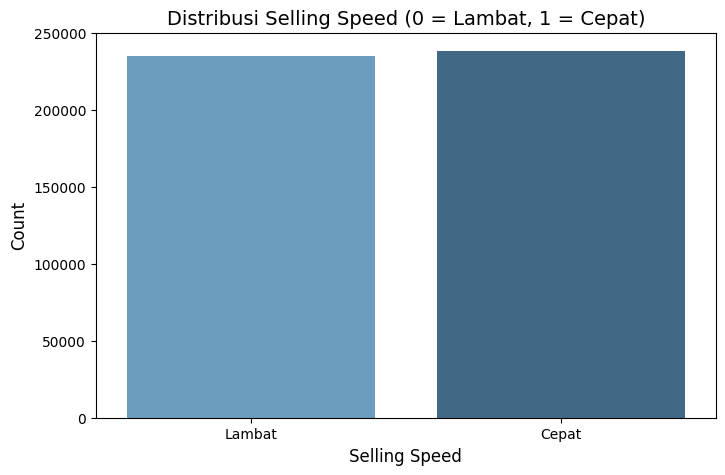

,selling_speed,count
0,1,238130
1,0,234831


In [ ]:
# Cek distribusi kategori selling_speed
selling_speed_dist = data.groupBy("selling_speed").count().toPandas()

# Visualisasi distribusi
plt.figure(figsize=(8, 5))
sns.barplot(data=selling_speed_dist, x="selling_speed", y="count", palette="Blues_d")
plt.title("Distribusi Selling Speed (0 = Lambat, 1 = Cepat)", fontsize=14)
plt.xlabel("Selling Speed", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Lambat', 'Cepat'])
plt.show()

selling_speed_dist
